## Step 1: Imports

In [2]:
import os
import mne
from mne.preprocessing import ICA
from autoreject import AutoReject
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import matplotlib.pyplot as plt

## Step 2: Load in the Data

In [3]:
# Define the root directory where BIDS-formatted data is stored.
bids_root = "/Users/BAEK/Code/neurEx/data/N170/N170 Raw Data BIDS-Compatible V2"

# Create a list of all directories in the bids_root folder that start with 'sub',
# indicating they are subject folders.
subjects = [sub for sub in os.listdir(bids_root) if sub.startswith('sub')]
'''
subjects = []
for sub in os.listdir(bids_root):
    if sub.startswith('sub'):
        subjects.append(sub)
'''

print("Subjects:", subjects)

# Select the first subject in the subjects list for processing.
subject = subjects[0]

# Define the task name, which will be used to construct the EEG data file paths.
task = 'task-N170'

# Construct the path to the subject's EEG file using the BIDS naming convention.
# This path includes the subject's folder, the 'eeg' subfolder, and the file name with both the subject ID and task included.
# The .set file is a complete data structure that stores both the EEG data(fdt) and annotations (events), along with all the relevant metadata. 
# It is the most comprehensive format for EEG data, especially when using tools like EEGLAB and MNE.
# The .fdt file is a binary file that stores the actual EEG signal, with each sample (point in time) recorded for each channel (electrode).
eeg_path = os.path.join(bids_root, subject, 'eeg', f'{subject}_{task}_eeg.set')

# Load the EEG data from the .set file into an MNE RawEEGLAB object.
# Setting preload=True loads the entire data into memory for faster processing.
raw = mne.io.read_raw_eeglab(eeg_path, preload=True)

raw

Subjects: ['sub-021', 'sub-026', 'sub-019', 'sub-010', 'sub-017', 'sub-028', 'sub-016', 'sub-029', 'sub-011', 'sub-027', 'sub-018', 'sub-020', 'sub-002', 'sub-005', 'sub-033', 'sub-034', 'sub-035', 'sub-032', 'sub-004', 'sub-003', 'sub-040', 'sub-025', 'sub-022', 'sub-014', 'sub-013', 'sub-012', 'sub-015', 'sub-023', 'sub-024', 'sub-039', 'sub-006', 'sub-001', 'sub-008', 'sub-037', 'sub-030', 'sub-031', 'sub-009', 'sub-036', 'sub-038', 'sub-007']
Reading /Users/BAEK/Code/neurEx/data/N170/N170 Raw Data BIDS-Compatible V2/sub-021/eeg/sub-021_task-N170_eeg.fdt
Reading 0 ... 570367  =      0.000 ...   556.999 secs...


<RawEEGLAB | sub-021_task-N170_eeg.fdt, 33 x 570368 (557.0 s), ~143.6 MB, data loaded>

## Step 3: Create a new event mapping for epoching

This creates a new event mapping that assigns specific condition labels (e.g., ‘Stimulus/Face’, ‘Response/Error’) to event codes (1-6) based on the original event codes (1-202). This mapping is used to define the event_id for epoching, ensuring that each event in the data is properly categorized for analysis.

In [4]:
# Create a dictionary of all integer event codes. This allows us to use the "events_from_annotations" MNE function to create our events array
# raw.annotations.description is an attribute of the raw object in MNE, and it contains the descriptions of the annotations in the EEG data. 
# These annotations typically represent specific events, stimuli, or markers in the data, such as stimulus presentations or subject responses.
# set() remove duplicates.
annotations_mapping = {desc: int(desc) for desc in set(raw.annotations.description)}
'''
annotations_mapping = {}
for desc in set(raw.annotations.description):
    annotations_mapping[desc] = int(desc)
'''

# Extracts events from the annotations stored in the raw object, translating them into an events array
# Events = an n events x 3 array
# Column 1 = The sample index(time) where each event(epoch) occurs. This corresponds to the point in the EEG recording when the event started.
# Column 2 = Always contains 0s (reserved for future use by MNE).
# Column 3 = The event type (A stimulus event code (e.g., 1-180) corresponding to a stimulus shown & A response event code (e.g., 201 or 202) corresponding to the participant’s answer).
# _ : A dictionary containing the mapping between event codes and annotation descriptions. You can ignore it if you’ve already provided your own mapping (like annotations_mapping).
# event_id : uses the annotations_mapping to translate the event descriptions in the raw annotations to their corresponding integer IDs.
events, _ = mne.events_from_annotations(raw, event_id = annotations_mapping)

# Create a mapping from original event codes to condition labels
# Each number from 1-180 and 201-202 have an associated event
event_code_to_condition = {}

# Map "1-40" to "Stimulus - faces"
for code in range(1, 41):
    event_code_to_condition[code] = 'Stimulus/Face'
# Map "41-80" to "Stimulus - cars"
for code in range(41, 81):
    event_code_to_condition[code] = 'Stimulus/Car'
# Map "101-140" to "Stimulus - scrambled faces"
for code in range(101, 141):
    event_code_to_condition[code] = 'Stimulus/ScrambledFace'
# Map "141-180" to "Stimulus - scrambled cars"
for code in range(141, 181):
    event_code_to_condition[code] = 'Stimulus/ScrambledCar'

# Map "201" to "Response - correct"
event_code_to_condition[201] = 'Response/Correct'
# Map "202" to "Response - error"
event_code_to_condition[202] = 'Response/Error'

# Assign new integer event IDs to each condition label
condition_label_to_event_id = {
    'Stimulus/Face': 1,
    'Stimulus/Car': 2,
    'Stimulus/ScrambledFace': 3,
    'Stimulus/ScrambledCar': 4,
    'Response/Correct': 5,
    'Response/Error': 6
}

# Create a mapping from original event codes to new integer event IDs
original_to_new_event_id = {}

# Iterates through each event code (1-180 and 201-202)
for code in event_code_to_condition:
    # Extracts the condition label associated with the event code
    condition_label = event_code_to_condition[code]
    # Finds the new event code (1-6) that corresponds to the condition label
    new_event_id = condition_label_to_event_id[condition_label]
    # Creates new event code array where each event code (1-202) is mapped to its new event code (1-6)
    original_to_new_event_id[code] = new_event_id

# Apply the event ID mapping to the events array
# Based on the original event codes (1 to 202), new event codes (1 to 6) are assigned to each event
events[:, 2] = np.array([original_to_new_event_id.get(code, -1) for code in events[:, 2]])
'''
new_event_codes = []
for code in events[:, 2]:
    # Get the new event ID from the mapping, or -1 if the code is not found
    new_event_code = original_to_new_event_id.get(code, -1)
    new_event_codes.append(new_event_code)
events[:, 2] = np.array(new_event_codes)
'''

# A safeguard to ensure that no invalid or erroneous event codes are present in the events array
# Remove events with code -1 (events not in our mapping)
events = events[events[:, 2] != -1]

# Define the event_id mapping for epoching
event_id = condition_label_to_event_id

Used Annotations descriptions: ['1', '10', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7',

## Step 4: Create the montage (EEG channels used) and add it to the epoch object

In [5]:
# EEG and EOG (electrooculography) channels need to be distinguished because they measure different types of electrical activity. 
# EEG channels measure brain activity, while EOG channels measure eye movements (important for rejecting artifacts in EEG data caused by eye movements).
# Marking them as EOG channels so that they can be treated differently in subsequent analysis.
eog_channels = ['HEOG_left', 'HEOG_right', 'VEOG_lower']
for ch in eog_channels:
    if ch in raw.ch_names:
        raw.set_channel_types({ch: 'eog'})

# This creates a digMontage object
# The montage is primarily used for visualization and spatial analysis in EEG data.
# The montage essentially provides the spatial coordinates (like x, y, and z positions) for each electrode, allowing you to translate those numerical channel labels (like Fp1, C3, etc.) into real-world 2D or 3D locations on the scalp or head.
# A digMontage object contains each electrode and the positional data associated from the scalp (a standardized layout based on the 10-20 system).
montage = mne.channels.make_standard_montage('standard_1020')

# This sets the montage in the rawEEGLAB object by attaching the electrode positions to the EEG channels
# The events array typically just contains event markers (like stimulus presentations or participant responses) and is not concerned with spatial information or electrode locations. 
# The events are timestamps related to specific points in time in the EEG data, but they don’t need to be “spatially” linked like EEG channels.
# Since the montage only applies to EEG channels and provides positional information (for visualization, etc.), it is applied only to the raw data object, which contains the channels.
raw.set_montage(montage, match_case=False)

<RawEEGLAB | sub-021_task-N170_eeg.fdt, 33 x 570368 (557.0 s), ~143.6 MB, data loaded>

### IGNORE THE DETAILS OF THIS CODE FOR NOW, IT IS JUST FOR VISUALIZATION PURPOSES

### Averaged EEG responses (ERP)

Not setting metadata
643 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 643 events and 820 original time points ...
1 bad epochs dropped


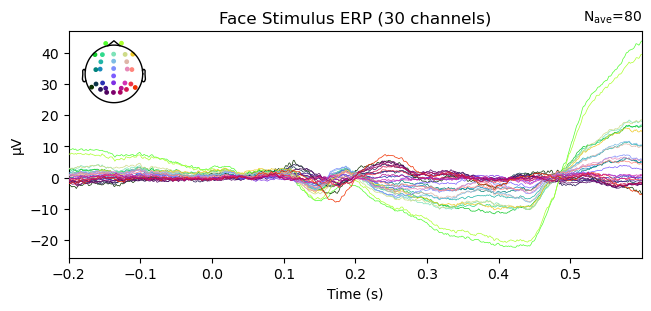

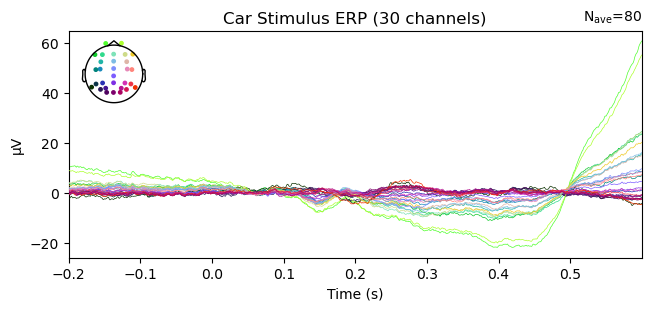

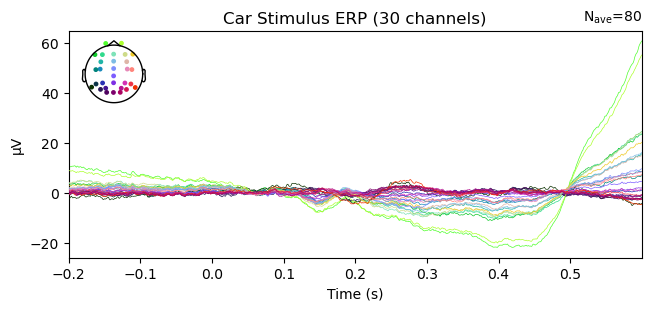

In [6]:
# The specific numbers used for tmin and tmax (like tmin = -0.2 and tmax = 0.6) are typically chosen based on common practices in EEG research and the characteristics of the event-related potentials (ERPs) or neural responses
tmin, tmax = -0.2, 0.6  # Time window from -200 ms to 600 ms

epochs = mne.Epochs(raw, events, event_id = event_id, tmin = tmin, tmax = tmax, baseline = None, preload = True, detrend = 1)

# Compute the average (evoked) response for each condition
evoked_face = epochs['Stimulus/Face'].average()
evoked_Car = epochs['Stimulus/Car'].average()

# Plot the averaged responses
# Plotting the ERP for 'Stimulus/Face'
evoked_face.plot(titles={'eeg': 'Face Stimulus ERP'}, spatial_colors=True)

# Plotting the ERP for 'Stimulus/Object'
evoked_Car.plot(titles={'eeg': 'Car Stimulus ERP'}, spatial_colors=True)

## Step 5: Preprocessing

### Step 5a: Filter

Removing unwanted noise and focusing on the frequencies that are of interest

1. Bandpass Filtering (0.1 Hz to 30 Hz)

The bandpass filter allows frequencies within a specific range to pass through while blocking frequencies outside that range.

2. Why the specific range (0.1-30 Hz)?:

0.1 Hz: EEG signals typically contain low-frequency components associated with brain activity, but frequencies below 0.1 Hz may represent very slow fluctuations, such as drift or movement artifacts. The lower limit of 0.1 Hz helps remove such slow drifts or high-amplitude noise.

30 Hz: Most of the important brain activity for typical EEG analysis lies within this range (particularly in the alpha, beta, and theta frequency bands). High-frequency noise from muscle activity or power line interference usually occurs above 30 Hz, so this upper limit removes that noise.

3. Why Bandpass?:

A bandpass filter is typically used because it preserves the brain’s activity (especially in certain frequency bands, like alpha, beta, theta) while filtering out both high-frequency noise (e.g., muscle activity or power-line interference) and low-frequency noise (e.g., drift or motion artifacts).

4. Why Firwin?:

The firwin design is a method for designing FIR (Finite Impulse Response) filters. FIR filters are ideal for EEG data because they are non-recursive, meaning their output only depends on the current and previous input values. This makes them numerically stable and ideal for EEG, where precision and control are needed.

FIR filters are preferred for their phase-linear properties, which means they do not distort the waveform in a way that could affect the timing of events in the EEG signal.


5. Notch Filtering at 60 Hz

A notch filter is used to remove a specific frequency band, typically where unwanted noise is present.

6. Why 60 Hz?:

In many countries, the electricity supply operates at 60 Hz (or 50 Hz in some regions), and this power line interference can appear as noise in the EEG signal at this frequency. The notch filter is applied to remove this specific interference without affecting other frequencies in the EEG signal.

7. Why Firwin?:

As with the bandpass filter, the firwin method is being used for designing the notch filter as well, ensuring that the notch filter is implemented with a FIR design to maintain phase linearity and signal integrity.

In [7]:
# Bandpass filter the data between 0.1Hz and 30Hz using a "firwin" filter
raw.filter(0.1, 30., fir_design='firwin')

# Apply notch filter at 60 Hz using a "firwin" filter
raw.notch_filter(60., fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 33793 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 6759 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


<RawEEGLAB | sub-021_task-N170_eeg.fdt, 33 x 570368 (557.0 s), ~143.6 MB, data loaded>

### IGNORE THE DETAILS OF THIS CODE FOR NOW, IT IS JUST FOR VISUALIZATION PURPOSES

### Averaged EEG responses (ERP)

Not setting metadata
643 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 643 events and 820 original time points ...
1 bad epochs dropped


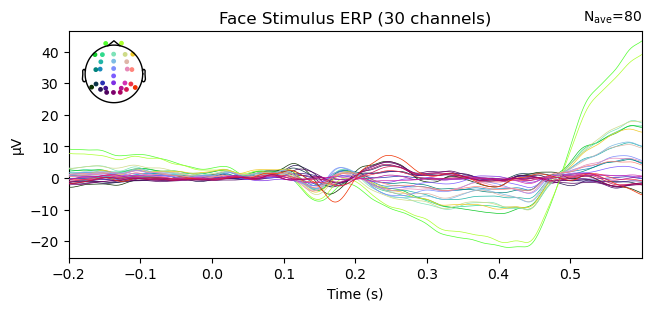

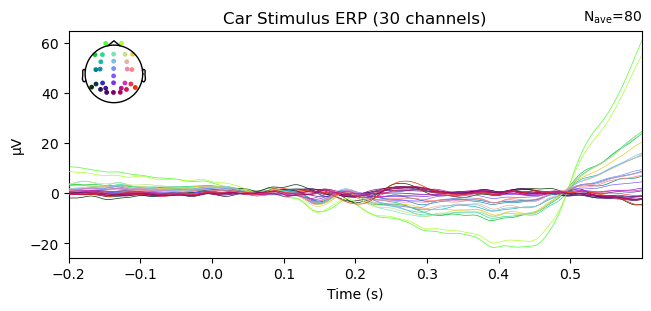

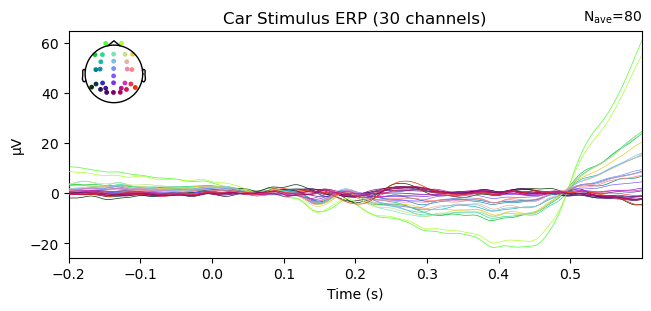

In [8]:
# The specific numbers used for tmin and tmax (like tmin = -0.2 and tmax = 0.6) are typically chosen based on common practices in EEG research and the characteristics of the event-related potentials (ERPs) or neural responses
tmin, tmax = -0.2, 0.6  # Time window from -200 ms to 600 ms

epochs = mne.Epochs(raw, events, event_id = event_id, tmin = tmin, tmax = tmax, baseline = None, preload = True, detrend = 1)

# Compute the average (evoked) response for each condition
evoked_face = epochs['Stimulus/Face'].average()
evoked_Car = epochs['Stimulus/Car'].average()

# Plot the averaged responses
# Plotting the ERP for 'Stimulus/Face'
evoked_face.plot(titles={'eeg': 'Face Stimulus ERP'}, spatial_colors=True)

# Plotting the ERP for 'Stimulus/Object'
evoked_Car.plot(titles={'eeg': 'Car Stimulus ERP'}, spatial_colors=True)

### Step 5b: Re-Reference

Re-referencing after filtering ensures that the EEG signal is clean and noise-free before the reference is adjusted, which improves the accuracy of the re-referencing process.

This step helps remove common-mode noise and improves the interpretability and quality of the EEG signal by making it easier to detect specific brain responses, such as the N170.

Before filtering, the raw EEG data might contain noise or unwanted low-frequency drifts that could affect the quality of the filtering process. This noise could be common across all channels, like power-line interference or other systemic artifacts.

By re-referencing to the average of all channels after filtering, you eliminate this common noise from the entire dataset, allowing the filter to operate on the cleaned signal. This means the filter will be applied more effectively to the brain activity you’re interested in, not to extraneous noise.

In [9]:
# Re-reference to the average of all channels
raw.set_eeg_reference(ref_channels = 'average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEEGLAB | sub-021_task-N170_eeg.fdt, 33 x 570368 (557.0 s), ~143.6 MB, data loaded>

### IGNORE THE DETAILS OF THIS CODE FOR NOW, IT IS JUST FOR VISUALIZATION PURPOSES

### Averaged EEG responses (ERP)

Not setting metadata
643 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 643 events and 820 original time points ...
1 bad epochs dropped


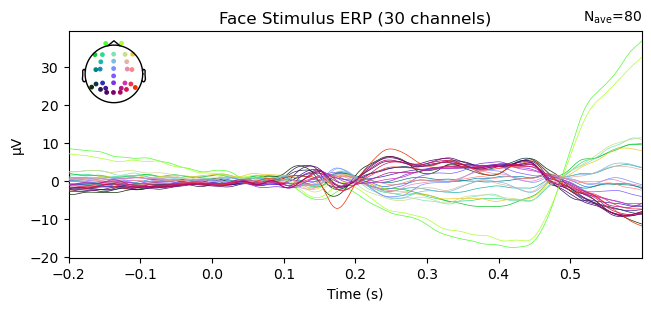

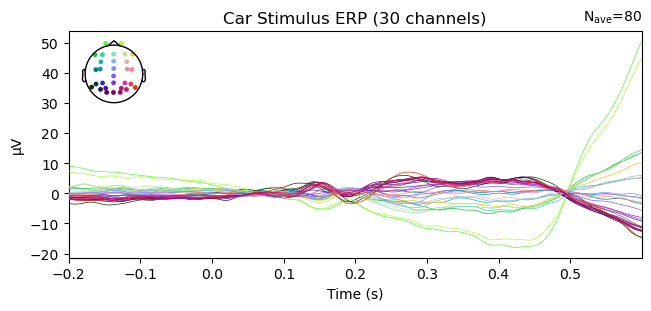

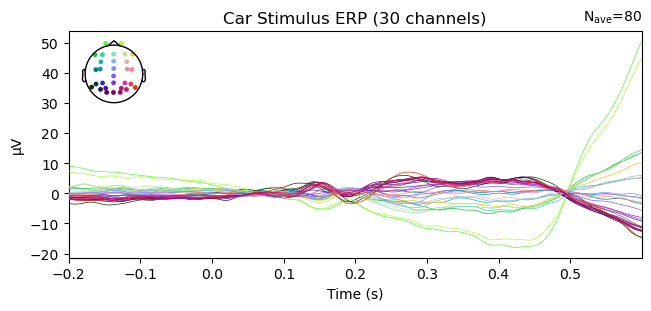

In [10]:
# The specific numbers used for tmin and tmax (like tmin = -0.2 and tmax = 0.6) are typically chosen based on common practices in EEG research and the characteristics of the event-related potentials (ERPs) or neural responses
tmin, tmax = -0.2, 0.6  # Time window from -200 ms to 600 ms

epochs = mne.Epochs(raw, events, event_id = event_id, tmin = tmin, tmax = tmax, baseline = None, preload = True, detrend = 1)

# Compute the average (evoked) response for each condition
evoked_face = epochs['Stimulus/Face'].average()
evoked_Car = epochs['Stimulus/Car'].average()

# Plot the averaged responses
# Plotting the ERP for 'Stimulus/Face'
evoked_face.plot(titles={'eeg': 'Face Stimulus ERP'}, spatial_colors=True)

# Plotting the ERP for 'Stimulus/Object'
evoked_Car.plot(titles={'eeg': 'Car Stimulus ERP'}, spatial_colors=True)

### Step 5c: Apply ICA

ICA separates the raw EEG signal into multiple independent components. These components represent different signal sources, including brain activity, eye movements (EOG), and other noise/artifacts.

Using the ica.find_bads_eog function, we identify which independent components are most strongly correlated with eye movement signals (EOG channels). These components represent the influence of EOG artifacts on the EEG data.

The identified EOG-related components are excluded (ica.exclude = eog_indices), and the remaining components are used to reconstruct the EEG signal. This creates a “cleaned” version of the data (raw_corrected) where the influence of eye movements has been removed.

1. What is ICA

ICA is a computational technique used to separate mixed signals into statistically independent components.

In the case of EEG data, multiple signals (such as brain activity, eye movements, and muscle activity) are mixed together in the recordings. ICA is used to decompose this mixture into individual, statistically independent sources, which can then be manipulated or removed based on the type of noise or artifact you’re trying to address.

EEG data often consist of high-dimensional signals with many channels (e.g., 64, 128, or even more). The goal of ICA is to reduce the dimensionality of the data by extracting independent components (ICs) that represent sources of activity, which could be brain signals or artifacts.

2. Why Do We Apply ICA in EEG Data Processing?

In EEG studies, artifacts like eye movements (blinks, saccades) or muscle activity can distort the brain’s electrical signals, leading to inaccurate analyses. The goal is to remove or correct for these artifacts so that the true brain activity can be isolated and analyzed without interference from extraneous sources.

For instance, EOG artifacts (generated by eye movements such as blinks or horizontal movements) are common and can obscure EEG data, especially when studying brain responses to visual stimuli, like the N170 event-related potential (ERP).

3. n_components = 15

The choice of 15 components is a balance between capturing enough data variability and avoiding overfitting. ICA is used to decompose the raw EEG data into independent components (ICs), which represent distinct sources of brain activity or artifacts.

If you choose too few components, you may not capture all the relevant information, including subtle brain activity patterns.

If you choose too many components, you risk including noise or non-relevant sources of variance in the data.

For a typical EEG experiment, 15–25 components are common.

4. method = 'fastica'

FastICA is one of the most commonly used algorithms for Independent Component Analysis in EEG/MEG data. It is a robust and efficient algorithm designed to separate mixed signals into independent components.

Efficiency: FastICA is relatively fast compared to other ICA algorithms (such as Infomax), and it converges quickly in most cases.

Reliability: FastICA has been extensively tested and used in a variety of applications, including EEG artifact removal, and it is known to work well in many real-world data scenarios.

While other ICA methods (e.g., Infomax) might work better in some specific situations (e.g., when working with very noisy data), FastICA is generally a good default method for many EEG applications, particularly for removing artifacts.

5. random_state = 97

The random_state parameter ensures that the results of ICA are reproducible. ICA is an iterative algorithm that relies on initial random values to start the optimization process. Different initializations can lead to different results (in terms of which components are identified).
By setting the random_state, you ensure that each time you run the ICA algorithm, you get the same result, which is essential for reproducibility of your results.

You can set any number for the random_state, but using a fixed value like 97 helps ensure consistency, making it easier to compare results across different runs or collaborators.

If random_state is not set (i.e., random_state=None), each run may produce slightly different results, which can introduce variability into your analysis.

The number 97 is just a seed for the random number generator. Any fixed number (e.g., 42, 123, 0, or 97) can be used for this purpose, and it doesn’t affect the outcome as long as the same number is used across experiments.

6. max_iter = 'auto'

The max_iter parameter defines the maximum number of iterations for the ICA algorithm to converge. By setting max_iter = 'auto', you allow the algorithm to determine the number of iterations based on the data’s convergence behavior.

Convergence: ICA algorithms require iterative optimization, and 'auto' ensures that the algorithm will stop once it has converged to a solution.

If the number of iterations is too low, the algorithm may not have enough time to converge, resulting in inaccurate components. If it’s too high, it might unnecessarily increase computation time.

Using 'auto' is often a safe choice, as the algorithm will adapt to the needs of the dataset. However, you can manually specify a number of iterations if you want to control the process more precisely, especially if you are debugging or need more fine-grained control over performance.

In [11]:
# Apply ICA to remove EOG (eye movement) artifacts
# Eye movements such as blinks create distortions in our data called "artifacts". These distortions can mask physiological data we are trying to extract
# number of components = 15
# method = 'fastica'
# random_state = 97
# max_iter = 'auto'
ica = ICA(n_components = 15, method = 'fastica', random_state = 97, max_iter = 'auto')

# Apply the ica to the raw data
# Computes the ICA decomposition on the entire EEG dataset.
# Finds a set of independent components that best explain the variance in the data. 
ica.fit(raw)

# Find ICA components correlated with EOG artifacts
# Identifies which ICA components are most correlated with the EOG channels. These components are likely to represent eye-movement artifacts.
eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name = eog_channels)

# Exclude the found EOG artifacts
# The indices of these components (eog_indices) are marked as bad
ica.exclude = eog_indices

# Apply the ICA solution to raw data to exclude the artifacts
# Reconstructs the EEG data, excluding the marked (EOG-related) components.
# raw.copy() ensures that the original raw data remains unchanged while the ICA-corrected data is stored in a separate variable (raw_corrected)
raw_corrected = ica.apply(raw.copy())

raw_corrected

Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 109.6s.
Using EOG channels: HEOG_left, HEOG_right, VEOG_lower
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 s)



/opt/miniconda3/envs/neur/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 s

<RawEEGLAB | sub-021_task-N170_eeg.fdt, 33 x 570368 (557.0 s), ~143.6 MB, data loaded>

### IGNORE THE DETAILS OF THIS CODE FOR NOW, IT IS JUST FOR VISUALIZATION PURPOSES

### Averaged EEG responses (ERP)

Not setting metadata
643 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 643 events and 820 original time points ...
1 bad epochs dropped


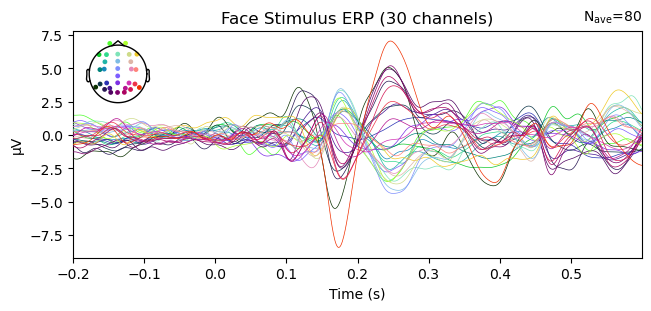

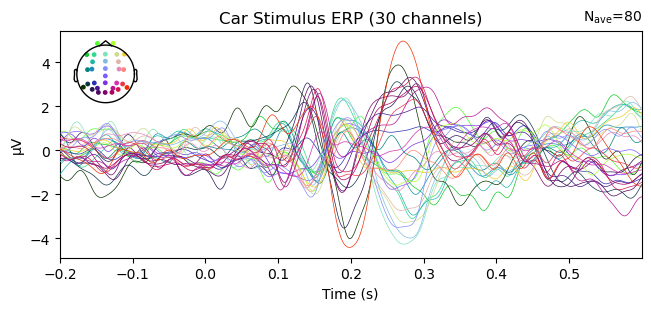

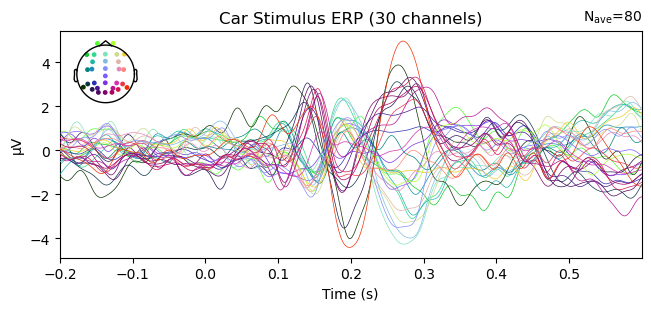

In [12]:
# The specific numbers used for tmin and tmax (like tmin = -0.2 and tmax = 0.6) are typically chosen based on common practices in EEG research and the characteristics of the event-related potentials (ERPs) or neural responses
tmin, tmax = -0.2, 0.6  # Time window from -200 ms to 600 ms

epochs = mne.Epochs(raw_corrected, events, event_id = event_id, tmin = tmin, tmax = tmax, baseline = None, preload = True, detrend = 1)

# Compute the average (evoked) response for each condition
evoked_face = epochs['Stimulus/Face'].average()
evoked_Car = epochs['Stimulus/Car'].average()

# Plot the averaged responses
# Plotting the ERP for 'Stimulus/Face'
evoked_face.plot(titles={'eeg': 'Face Stimulus ERP'}, spatial_colors=True)

# Plotting the ERP for 'Stimulus/Object'
evoked_Car.plot(titles={'eeg': 'Car Stimulus ERP'}, spatial_colors=True)

Step 6: Create the MNE epochs object

In [13]:
# The specific numbers used for tmin and tmax (like tmin = -0.2 and tmax = 0.6) are typically chosen based on common practices in EEG research and the characteristics of the event-related potentials (ERPs) or neural responses
tmin, tmax = -0.2, 0.6

# The baseline is a specific time interval, usually just before the stimulus onset (e.g., -200 ms to 0 ms in this case). During this time, the brain is assumed to be in a neutral or resting state, unaffected by the upcoming stimulus.
# Pre-Stimulus Activity: It captures brain activity just before the stimulus, which is least likely to be influenced by the event itself.
baseline = (tmin, 0)

epochs = mne.Epochs(
    raw = raw_corrected,       # Use the corrected raw data after ICA
    events = events,           # The events array created from annotations
    event_id = event_id,       # The dictionary mapping events to labels
    tmin = tmin,               # Start of the time window (-0.2 seconds)
    tmax = tmax,               # End of the time window (0.6 seconds)
    baseline = baseline,       # Baseline interval from -0.2 to 0 seconds
    preload = True,            # Preload data for faster access
    detrend = 1                # Linear detrending to remove DC offset
)

Not setting metadata
643 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 643 events and 820 original time points ...
1 bad epochs dropped


### Step 7: Reject bad epochs due to movement artifacts.

Movement artifacts are like EOG artifacts, except they are caused by bodily movement, such as shaking your head, or moving aronud in your seat during recording. Epochs with movement corrupted data need to be removed so that they do not hinder analysis.

EOG (Eye Movements) vs. Body Movements in EEG Data:

1.	EOG Artifacts:

    Nature: Eye movements and blinks produce signals that are structured and often overlap with the frequency range of EEG signals (e.g., alpha waves).

    Subtlety: They can look similar to EEG signals but have distinct spatial patterns.

    Use ICA to separate out these structured signals because it identifies independent sources of variation (like eye-related activity) and removes them selectively.

    EOG signals aren’t always extreme in amplitude but are systematic enough to require advanced techniques like ICA.

2.	Body Movement Artifacts:

    Nature: Body movements cause large, abrupt fluctuations in the EEG signal due to electrode displacements or muscle activity.

    Obviousness: These artifacts are typically much larger and more irregular, making them easier to detect.

    Use tools like Autoreject or simple amplitude-based thresholding to identify and exclude these epochs.

    Since these artifacts are less structured and more disruptive, they are better handled by outright rejection or repair.

Autoreject(findchangepts in MATLAB) is a tool designed to detect and reject bad epochs or repair them in EEG data. It automatically identifies epochs (time-locked segments of EEG data) containing excessive noise or artifacts, such as those caused by head movements, muscle activity, or other environmental factors.

It identifies individual epochs with large signal deviations or noise that exceed certain thresholds. These artifacts might arise from head movement, muscle contractions, or hardware interference.

The fit_transform() function in Autoreject:
1.	Fits the model to the data by learning the noise levels and thresholds for each channel.
2.	Transforms the data by either rejecting or repairing noisy epochs.

return_log=True: This option returns a reject_log object, which contains information about which epochs were rejected or repaired. This can be useful for troubleshooting or documentation.

In [14]:
# Apply Autoreject to automatically reject bad epochs
ar = AutoReject()

# Apply the auto rejection to the epochs object we created
# This can be achieved with SKLearns fit_transform function
epochs_clean, reject_log = ar.fit_transform(epochs, return_log = True)

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/30 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/30 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/642 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/642 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/642 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/642 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/642 [00:00<?,       ?it/s]

Dropped 38 epochs: 47, 65, 69, 84, 93, 97, 111, 113, 121, 149, 159, 160, 161, 208, 209, 226, 250, 313, 327, 329, 337, 353, 368, 369, 383, 418, 428, 429, 451, 459, 493, 529, 565, 568, 569, 572, 573, 639


### Step 8: Apply the baseline correction

Use baseline correction to adjust the data in each epoch so that it has a consistent starting point across all trials(standardize all epochs).

Baseline correction adjusts the signal so that each epoch is centered around a baseline period, which typically occurs before the event of interest (e.g., stimulus onset).

The typical order of preprocessing steps in EEG analysis is to apply baseline correction after you have completed the steps for filtering, artifact rejection, and any other necessary data cleaning processes.

In [15]:
# Apply baseline correction after artifact rejection
epochs_clean.apply_baseline(baseline = baseline)

Applying baseline correction (mode: mean)


<Epochs | 604 events (all good), -0.2 – 0.6 s (baseline -0.2 – 0 s), ~124.7 MB, data loaded,
 'Stimulus/Face': 77
 'Stimulus/Car': 77
 'Stimulus/ScrambledFace': 79
 'Stimulus/ScrambledCar': 77
 'Response/Correct': 268
 'Response/Error': 26>

### Step 9: Visualization

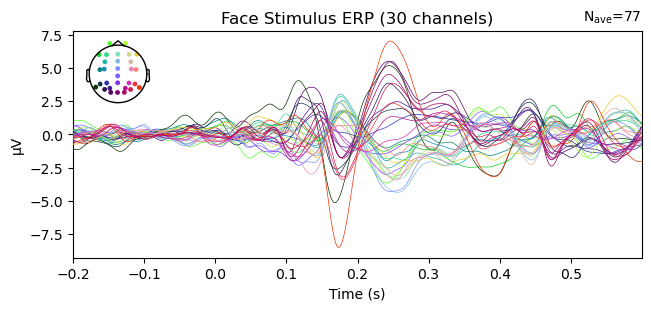

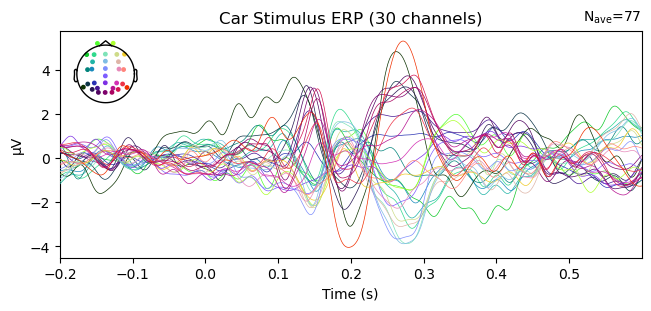

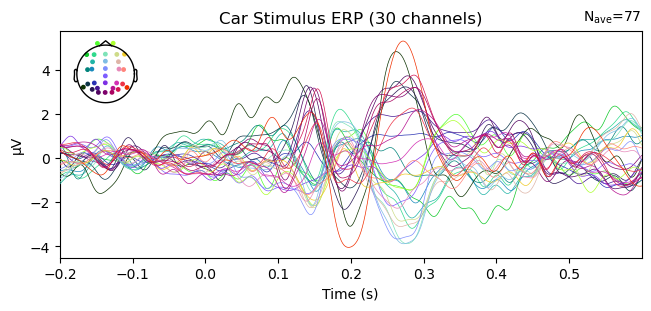

In [16]:
# Simply compute the average (evoked) response for each condition
# Use the .average() function on the face and car stimulus data from epochs_clean
evoked_face = epochs_clean['Stimulus/Face'].average()
evoked_Car = epochs_clean['Stimulus/Car'].average()

# Plotting the ERP for Face
# Use mne's plot function with the parameters:
# titles = {'eeg': 'Face Stimulus ERP'}, spatial_colors=True
evoked_face.plot(titles={'eeg': 'Face Stimulus ERP'}, spatial_colors=True)
# plt.savefig('average_erp_face.png') # Optional: Save the plot!

# Plotting the ERP for Object
# Use mne's plot function with the parameters:
# titles = {'eeg': 'Car Stimulus ERP'}, spatial_colors=True
evoked_Car.plot(titles={'eeg': 'Car Stimulus ERP'}, spatial_colors=True)

### Step 10: Z-Score Normalization and Resampling to Balance Classes

1. X

NumPy arrays are multidimensional data structures. Each dimension corresponds to a different aspect of the data.

First Dimension (595):
•	Represents 595 epochs (or trials) in your experiment. Each epoch corresponds to a single trial where the EEG data is collected during a stimulus presentation or event.
	•	This dimension will vary as you add more subjects or trials, but each epoch will contain data in the format specified by the next two dimensions.

Second Dimension (33):
•	Represents 33 EEG channels (electrodes) capturing data from various scalp locations. Each channel corresponds to a different electrode that records electrical activity from the brain.
•	These 33 channels provide spatial information about where the brain activity is occurring on the scalp.
•	This dimension will remain the same across all subjects, as you are using the same number of electrodes to capture the data.

Third Dimension (820):
•	Represents 820 time points for each epoch. These are the EEG values recorded over time during each trial. The EEG signal is continuous, and the time points correspond to the sampling rate and the duration of the recording.
•	This dimension also remains the same across all subjects, as the data is sampled at the same rate and duration for each trial.

2. For example 

import numpy as np
box = np.random.rand(10, 20, 5)  # Generate random values in a (10, 20, 5) shape
print(box)

  array([[[0.72, 0.43, 0.99, 0.58, 0.16],  # Epoch 1, Channel 1
          [0.63, 0.34, 0.88, 0.44, 0.01],  # Epoch 1, Channel 2
          ...
          [0.56, 0.11, 0.98, 0.75, 0.22]], # Epoch 1, Channel 20
         [[0.89, 0.22, 0.78, 0.33, 0.55],  # Epoch 2, Channel 1
          [0.71, 0.48, 0.64, 0.88, 0.19],
          ...
          [0.12, 0.95, 0.72, 0.66, 0.23]], # Epoch 2, Channel 20
          ...
         [[0.82, 0.73, 0.61, 0.88, 0.34],  # Epoch 10, Channel 1
          [0.44, 0.56, 0.77, 0.93, 0.18],
          ...
          [0.62, 0.29, 0.38, 0.99, 0.41]]  # Epoch 10, Channel 20
        ])

Step 1: Mapping xx to Excel Files

The structure of your EEG data (xx) can be thought of as:
	•	Rows in the Excel sheet (y-axis): These correspond to the 33 EEG channels.
	•	Columns in the Excel sheet (x-axis): These correspond to the 820 time points.
	•	Multiple Excel sheets (z-axis): Each sheet corresponds to one epoch (595 epochs total).

Imagine one epoch of data as a single Excel file. For Epoch 1, you have a 33×820 table:

Channel/Time	 t1	    t2	 t3	  …	t820
         Ch1	0.12	-0.34	0.56	…	0.44
         Ch2	0.15	-0.23	0.54	…	0.39
         Ch3	0.10	-0.18	0.45	…	0.35
          …	   …	    …	   …	  …	 …
         Ch33	0.22	-0.28	0.67	…	0.50

Step 3: Visualizing Across Epochs

Now, you stack 595 Excel files one on top of the other. Each file has the same dimensions (33×820), but the data values inside them differ because each epoch captures a slightly different response (depending on the stimulus, noise, or other factors).

Step 4: Linking to the Labels (yy)

Each Excel file (epoch) corresponds to a single value in yy, which indicates the event type or condition. For example:

Epoch	Label (Event Type)
  1	    1   (Face stimulus)
  2	    2   (Car stimulus)
  3    	1   (Face stimulus)
  …	    …       …
 595   	4   (Scrambled car)

Step 5: Overall Data Structure

Think of your data as 595 Excel files:
•	Each file has 33 rows (EEG channels) and 820 columns (time points).
•	You also have a separate label file (yy) that tells you what condition or event type corresponds to each Excel file.
•	For the table we created for epoch 1 with a 33×820 table, it's name is 1 (Face stimulus) according to yy.
•	x (first dimension): Epochs (each epoch is like a “table”).
•	y (second dimension): Channels (columns in the table).
•	z (third dimension): Time points (rows in the table).

3. Normalization (Z-score normalization)

Normalization is a standard pre-processing step in machine learning and signal processing to ensure that all features (in this case, the EEG signal values across all epochs) are on the same scale. Without normalization, features with larger scales (like EEG channels with higher amplitude signals) might dominate over features with smaller scales (like signals with less variance). This can make the training of machine learning models less effective.

Z-score Normalization is a type of standardization, where we scale the data such that it has a mean of 0 and a standard deviation of 1. 

Z = \frac{X - \mu}{\sigma}

Where:
•	X is the original data point (EEG signal value at a specific time and channel),
•	\mu is the mean of the data (average signal value),
•	\sigma is the standard deviation (how much the data varies from the mean).

This normalization ensures that the data has a consistent scale, which helps improve the performance of machine learning algorithms, especially deep learning models.

4. For example 

x = [
    [1, 2, 3, 4],  # Epoch 1
    [5, 6, 7, 8],  # Epoch 2
    [9, 10, 11, 12] # Epoch 3
]

Here, each row corresponds to an epoch (a trial), and each column corresponds to a feature (in this case, 4 features).
	•	Epoch 1: [1, 2, 3, 4]
	•	Epoch 2: [5, 6, 7, 8]
	•	Epoch 3: [9, 10, 11, 12]

Step-by-Step Z-Score Normalization


Mean and Standard Deviation Calculation:
For each feature (column), we calculate the mean and standard deviation:
	
  •	Mean of Feature 1:  \frac{1 + 5 + 9}{3} = 5 
	•	Mean of Feature 2:  \frac{2 + 6 + 10}{3} = 6 
	•	Mean of Feature 3:  \frac{3 + 7 + 11}{3} = 7 
	•	Mean of Feature 4:  \frac{4 + 8 + 12}{3} = 8 
	
  •	Standard Deviation of Feature 1:
 \sqrt{\frac{(1-5)^2 + (5-5)^2 + (9-5)^2}{3}} = 3.464 
	•	Standard Deviation of Feature 2:
 \sqrt{\frac{(2-6)^2 + (6-6)^2 + (10-6)^2}{3}} = 3.464 
	•	Standard Deviation of Feature 3:
 \sqrt{\frac{(3-7)^2 + (7-7)^2 + (11-7)^2}{3}} = 3.464 
	•	Standard Deviation of Feature 4:
 \sqrt{\frac{(4-8)^2 + (8-8)^2 + (12-8)^2}{3}} = 3.464 

Apply Z-Score Normalization:

Z-score normalization is applied by the formula:

z = \frac{x - \mu}{\sigma}

where:
	•	 x  is the original value,
	•	 \mu  is the mean of the feature,
	•	 \sigma  is the standard deviation of the feature.
For Epoch 1, applying Z-score to each feature:
	•	Feature 1:  \frac{1 - 5}{3.464} = -1.155 
	•	Feature 2:  \frac{2 - 6}{3.464} = -1.155 
	•	Feature 3:  \frac{3 - 7}{3.464} = -1.155 
	•	Feature 4:  \frac{4 - 8}{3.464} = -1.155 
Normalized Epoch 1: [-1.155, -1.155, -1.155, -1.155]

Similarly, apply the Z-score normalization for Epoch 2 and Epoch 3:

Normalized Epoch 2:
	•	Feature 1:  \frac{5 - 5}{3.464} = 0 
	•	Feature 2:  \frac{6 - 6}{3.464} = 0 
	•	Feature 3:  \frac{7 - 7}{3.464} = 0 
	•	Feature 4:  \frac{8 - 8}{3.464} = 0 
Normalized Epoch 2: [0, 0, 0, 0]

Normalized Epoch 3:
	•	Feature 1:  \frac{9 - 5}{3.464} = 1.155 
	•	Feature 2:  \frac{10 - 6}{3.464} = 1.155 
	•	Feature 3:  \frac{11 - 7}{3.464} = 1.155 
	•	Feature 4:  \frac{12 - 8}{3.464} = 1.155 
Normalized Epoch 3: [1.155, 1.155, 1.155, 1.155]

x = [
    [-1.155, -1.155, -1.155, -1.155],  # Epoch 1
    [0,     0,     0,     0    ],     # Epoch 2
    [1.155, 1.155, 1.155, 1.155]      # Epoch 3
]

5. Resample to balance classes

The purpose of this part of the code is to balance the class distribution in your dataset. This is typically done when you have imbalanced classes (i.e., one class is much more frequent than another), and you want to ensure that each class is equally represented in the training data.

This process uses RandomOverSampler to randomly duplicate examples from the minority class until both classes have the same number of samples.

    1. Imbalanced Classes in Data:

    •	In many real-world datasets, some classes (labels) are underrepresented, meaning there are fewer samples (data points) for those classes.
    •	For example, if you’re detecting an event in EEG data (like N170 for face recognition), the number of “face” events might be much lower than the number of “non-face” events.
    •	In an imbalanced dataset, there may be too few examples for the minority class to train the model effectively, leading to biased predictions.

    2. Why Resampling is Necessary:

    •	Training a Model: Most machine learning algorithms assume that the classes are somewhat equally represented. If one class is significantly underrepresented, the model may become biased and learn to predict the majority class more frequently.
    •	Impact of Imbalance:
    •	For example, if you have 1000 “non-face” events and only 100 “face” events, a model trained on such data might predict “non-face” for almost every input, because that would give a good accuracy rate. But this is clearly problematic, because you are not learning to recognize the minority class (“face”).

    3. How Resampling Helps:

    •	Random OverSampling: By duplicating the samples from the minority class, we are artificially increasing its representation in the dataset, making it equal in size to the majority class.
    •	This gives the model more opportunities to learn from the minority class.
    •	When we resample (e.g., by adding duplicates of the minority class), we’re not just giving the model “extra copies” of the exact same data.
    •	Instead, we’re ensuring that the model is exposed to the minority class more frequently, which increases the chances that the model will learn to recognize the minority class effectively.
    •	Even though the data points are the same, the model will process them multiple times as if they were distinct samples. This helps it learn the underlying features that are relevant to that class.

6. For example

x:
[[ 1,  2],  [ 2,  3],  [ 3,  4],  [ 4,  5],  
 [ 5,  6],  [ 6,  7],  [ 7,  8],  [ 8,  9],  [ 9, 10],  [10, 11]]

y:
[0, 0, 0, 0, 1, 1, 2, 2, 2, 2]

•	Class 0 has 4 samples (indices 0 to 3).
•	Class 1 has 2 samples (indices 4 to 5).
•	Class 2 has 4 samples (indices 6 to 9).

Original X shape: (10, 2)
Original Y shape: (10,)

The goal is to increase the number of samples in Class 1 to match Class 0 and Class 2, both of which have 4 samples. Since Class 1 only has 2 samples, we need to add 2 more samples, and RandomOverSampler achieves this by randomly duplicating the existing samples.

	  1.	First option: Duplicate both samples from Class 1: [5, 6], [6, 7]
    2.	Second option: Duplicate only the first sample from Class 1: [5, 6], [5, 6]
    3.	Third option: Duplicate only the second sample from Class 1: [6, 7], [6, 7]
    4.	Fourth option: Duplicate both sample from Class 1: [6, 7], [5, 6]

Resampled X shape: (12, 2)
Resampled Y shape: (12,)
y_resampled: [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2]

Final Dataset:

•	Class 0: 4 samples
•	Class 1: 4 samples (achieved by duplicating random samples from the original 2 samples)
•	Class 2: 4 samples


In [29]:
# Extracts the EEG data from the epochs_clean object. The data has the shape (n_epochs, n_channels, n_times), where:
# n_epochs: n_epochs: The number of epochs (each epoch corresponds to a time window around an event or stimulus).
# n_channels: The number of EEG channels.
# n_times: The number of time points in each epoch (i.e., the duration of each epoch sampled at a certain rate).
x = epochs_clean.get_data()  # Shape: (n_epochs, n_channels, n_times)

# Extracting the event labels for each epoch. epochs_clean.events is a matrix that contains the event markers for each epoch (rows), with the 3rd column ([:, 2]) representing the event code associated with each epoch
y = epochs_clean.events[:, 2]

# Assume we added all the data together using for loops
'''
all_epochs.append(x)
all_labels.append(y)
'''

# Stacks the arrays from all subfolders along the first dimension (epochs)
# The np.vstack() function stacks arrays vertically, which means it concatenates along the first dimension (also known as the “rows”)
# If you combine the data from three subjects (or sets of epochs), each with a shape of (595, 33, 820), (610, 33, 820), and (580, 33, 820), you end up with a total shape of: (1785, 33, 820)
# This means you now have 1785 epochs (tables) stacked together, with each table having 33 channels and 820 time points.
'''
x = np.vstack(all_epochs)
'''

# Concatenates all the 1D label arrays into a single array
'''
y = np.concatenate(all_labels)
'''

# Normalize the data (z-score normalization)
n_epochs_name, n_channels_rows, n_times_columns = x.shape # will return 3 integers (x,y,z)
# This line flattens the data from a 3D array (n_epochs, n_channels, n_times) into a 2D array of shape (n_epochs, n_channels * n_times). 
# For example, the shape before reshaping is (5, 3, 4), and after reshaping, it becomes (5, 12).
# Why flatten? The scikit-learn’s StandardScaler expects the data in a 2D array where the rows represent individual samples (epochs), and the columns represent features (in this case, EEG signal values at different time points for each channel).
# Flattening the data just reshapes it, meaning that the original order of the elements is maintained, but now the data is presented in a single row per epoch, where each element in the row corresponds to one specific EEG signal value.
x = x.reshape(n_epochs_name, -1) # solely for scaler
scaler = StandardScaler()
# Computes the mean and standard deviation for each feature (column) in the data and then transforms the data by applying the Z-score normalization. 
# After this, x will contain normalized values where each feature has zero mean and unit variance.
x = scaler.fit_transform(x)
# After normalization, the data is reshaped back to its original 3D format with the shape (n_epochs, n_channels, n_times)
x = x.reshape(n_epochs_name, n_channels_rows, n_times_columns)

# Resample to balance classes
# counter = Counter(y) count the number of occurrences of each class in y
# y contains the class labels, and Counter(y) will return the frequency of each label (e.g., how many epochs belong to class 0, how many belong to class 1, etc.).
# For example, y = [0, 1, 0, 1, 1, 0, 1] Output will be {1: 4, 0: 3}
counter = Counter(y)
# RandomOverSampler is a method from the imblearn library that is used to balance the class distribution by oversampling the minority class.
# random_state=42 is used to ensure reproducibility of the results. This means that the random sampling done by the RandomOverSampler will be the same each time the code is run.
# If there were an imbalance from the counter, RandomOverSampler would randomly duplicate epochs from the minority class (i.e., it would pick epochs from the minority class and copy them to increase its frequency until it matches the majority class).
ros = RandomOverSampler(random_state = 42)
# Create additional samples for the minority class by randomly duplicating the existing samples of that class until all classes have the same number of samples
# the data points from the minority class are copied to increase their count until they match the majority class, resulting in a balanced dataset.
x_resampled, y_resampled = ros.fit_resample(x.reshape(n_epochs_name, -1), y)
# The -1 in the reshape function allows NumPy to automatically calculate the appropriate size for that dimension based on the size of the other dimensions and the total number of elements in the array.
#  after resampling the data, the number of epochs (x_resampled.shape[0]) has changed, so we need to reshape the data accordingly while keeping the other dimensions (channels and time points) the same.
x = x_resampled.reshape(-1, n_channels_rows, n_times_columns)
y = y_resampled